# Example Notebook to load multiple dataset from different STAC catalogs

### import packages

In [2]:
# Created by Etiënne Kras, 24-10-2024, using geo_env
import pandas as pd
import pystac_client
import xarray as xr
import rioxarray as rio
import numpy as np
from typing import List, Dict
from copy import deepcopy
import matplotlib.colors as mcolors

### Functions

In [3]:
# define function(s)

# function to put items in dataframe
def items_to_dataframe(items: List[Dict]) -> pd.DataFrame:
    """STAC items to Pandas dataframe.

    Args:
        items (List[Dict]): _description_

    Returns:
        pd.DataFrame: _description_
    """
    _items = []
    for i in items:
        _i = deepcopy(i)
        _items.append(_i)
    df = pd.DataFrame(pd.json_normalize(_items))
    return df

def get_all_items_with_progress(collection, batch_size=100):
    """
    Get all items from a collection with progress tracking.
    This works even when the collection doesn't support search API.
    """
    print(f"Loading items from collection: {collection.id}")
    
    try:
        # Get the item iterator
        items_iter = collection.get_items()
        
        all_items = []
        batch = []
        
        for i, item in enumerate(items_iter, 1):
            batch.append(item)
            
            # Process in batches to show progress and manage memory
            if len(batch) >= batch_size:
                all_items.extend(batch)
                print(f"Loaded {len(all_items)} items...")
                batch = []
        
        # Add remaining items
        if batch:
            all_items.extend(batch)
            
        print(f"Finished loading {len(all_items)} total items")
        return all_items
        
    except Exception as e:
        print(f"Error loading items: {e}")
        return []


def get_collection_df(collection):
    name = "name"#collection
    print("Available assets in collection:")
    for asset_name, asset in collection.get_assets().items():
        print(f"  - {asset_name}: {asset.href}")

    # Try to find a parquet asset first, fallback to item loading
    if "geoparquet-stac-items" in collection.get_assets():
        print(f"Using fast parquet method for {name}...")
        items_df = pd.read_parquet(collection.get_assets()["geoparquet-stac-items"].href)
        print(f"Loaded {len(items_df)} items from parquet")
    else:
        print("\nNo parquet asset found, using get_items() with progress tracking...")
        items = get_all_items_with_progress(collection, batch_size=50)
        items_df = items_to_dataframe([i.to_dict() for i in items])
        print(f"Converted to DataFrame with {len(items_df)} rows")

    print("DataFrame info:")
    print(f"Shape: {items_df.shape}")

        
    return items_df

In [4]:
# load the CoCliCo STAC catalog
catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac/catalog.json"
)
# catalog
# see visually here: radiantearth.github.io/stac-browser/#/external/storage.googleapis.com/coclico-data-public/coclico/coclico-stac-4oct/catalog.json

# list the datasets present in the catalog, we are interested in the slp5 and slp6 sets
list(catalog.get_children())

c:\Users\athanasi\AppData\Local\miniforge3\envs\idp-dashboard\Lib\site-packages\pystac_client\client.py:191: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


[<CollectionClient id=floodmaps>,
 <CollectionClient id=cbca>,
 <CollectionClient id=cfr>,
 <CollectionClient id=smd>,
 <CollectionClient id=cisi>,
 <CollectionClient id=slp5>,
 <CollectionClient id=slp6>,
 <CollectionClient id=coastal-mask>,
 <CollectionClient id=ceed>,
 <CollectionClient id=slp>,
 <CollectionClient id=ssl>,
 <CollectionClient id=wef>,
 <CollectionClient id=eesl>,
 <CollectionClient id=sc>,
 <CollectionClient id=NUTS_CM>,
 <CollectionClient id=NUTS>,
 <CollectionClient id=LAU>,
 <CollectionClient id=gcts>,
 <CollectionClient id=deltares-delta-dtm>,
 <CollectionClient id=coastal-grid>,
 <CollectionClient id=LAU_CM>,
 <CollectionClient id=NUTS0_CM>,
 <CollectionClient id=NUTS2_CM>,
 <CollectionClient id=pp_maps>,
 <CollectionClient id=cfhp_all_maps>,
 <CollectionClient id=cfhp_all>,
 <CollectionClient id=ceed_maps>,
 <CollectionClient id=twl_SLR>,
 <CollectionClient id=twl_SLR_RP>,
 <CollectionClient id=pp_stats>,
 <CollectionClient id=cfhp_all_stats>,
 <CollectionClien

In [5]:
ar6_col = catalog.get_child("slp6")
items_ar6_df = get_collection_df(ar6_col)
items_ar6_df

Available assets in collection:
  - thumbnail: https://storage.googleapis.com/coclico-data-public/coclico/assets/thumbnails/slp6.png
  - geoparquet-stac-items: https://coclico.blob.core.windows.net/items/slp6.parquet
Using fast parquet method for name...
Loaded 4494 items from parquet
DataFrame info:
Shape: (4494, 17)


,type,stac_version,stac_extensions,id,geometry,bbox,links,assets,collection,proj:bbox,proj:shape,proj:geometry,proj:transform,datetime,proj:code,ssp,slr_ens
0,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=1-26\slr_ens0.0\2020.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2020-01-01,EPSG:4326,1-26,0.0
1,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=1-26\slr_ens0.1\2020.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2020-01-01,EPSG:4326,1-26,0.1
2,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=1-26\slr_ens0.5\2020.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2020-01-01,EPSG:4326,1-26,0.5
3,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=1-26\slr_ens1.0\2020.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2020-01-01,EPSG:4326,1-26,1.0
4,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=1-26\slr_ens2.0\2020.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2020-01-01,EPSG:4326,1-26,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=5-85\slr_ens98.0\2150.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2150-01-01,EPSG:4326,5-85,98.0
4490,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=5-85\slr_ens99.0\2150.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2150-01-01,EPSG:4326,5-85,99.0
4491,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=5-85\slr_ens99.5\2150.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2150-01-01,EPSG:4326,5-85,99.5
4492,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=5-85\slr_ens99.9\2150.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href

In [6]:
ar5_col = catalog.get_child("slp5")
items_ar5_df = get_collection_df(ar5_col)
items_ar5_df

Available assets in collection:
  - thumbnail: https://storage.googleapis.com/coclico-data-public/coclico/assets/thumbnails/slp5.png

No parquet asset found, using get_items() with progress tracking...
Loading items from collection: slp5


c:\Users\athanasi\AppData\Local\miniforge3\envs\idp-dashboard\Lib\site-packages\pystac_client\collection_client.py:153: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("ITEM_SEARCH")


Loaded 50 items...
Loaded 100 items...
Loaded 150 items...
Loaded 200 items...
Loaded 250 items...
Loaded 300 items...
Loaded 350 items...
Loaded 400 items...
Loaded 450 items...
Loaded 500 items...
Loaded 550 items...
Loaded 600 items...
Loaded 650 items...
Loaded 700 items...
Loaded 750 items...
Loaded 800 items...
Finished loading 846 total items
Converted to DataFrame with 846 rows
DataFrame info:
Shape: (846, 19)


,type,stac_version,stac_extensions,id,bbox,links,collection,geometry.type,geometry.coordinates,properties.proj:bbox,properties.proj:shape,properties.proj:epsg,properties.proj:geometry.type,properties.proj:geometry.coordinates,properties.proj:transform,properties.datetime,assets.data.href,assets.data.type,assets.data.roles
0,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,rcp=26\slr_ens5\2007-01-01_2008-01-01.tif,"[0.0, -90.0, 360.0, 90.0]","[{'rel': 'collection', 'href': '../../../colle...",slp5,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[0.0, -90.0, 360.0, 90.0]","[180, 360]",4326,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[1.0, 0.0, 0.0, 0.0, 1.0, -90.0]",2007-07-02T12:00:00Z,https://storage.googleapis.com/coclico-data-pu...,image/tiff; application=geotiff; profile=cloud...,[data]
1,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,rcp=26\slr_ens50\2007-01-01_2008-01-01.tif,"[0.0, -90.0, 360.0, 90.0]","[{'rel': 'collection', 'href': '../../../colle...",slp5,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[0.0, -90.0, 360.0, 90.0]","[180, 360]",4326,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[1.0, 0.0, 0.0, 0.0, 1.0, -90.0]",2007-07-02T12:00:00Z,https://storage.googleapis.com/coclico-data-pu...,image/tiff; application=geotiff; profile=cloud...,[data]
2,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,rcp=26\slr_ens95\2007-01-01_2008-01-01.tif,"[0.0, -90.0, 360.0, 90.0]","[{'rel': 'collection', 'href': '../../../colle...",slp5,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[0.0, -90.0, 360.0, 90.0]","[180, 360]",4326,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[1.0, 0.0, 0.0, 0.0, 1.0, -90.0]",2007-07-02T12:00:00Z,https://storage.googleapis.com/coclico-data-pu...,image/tiff; application=geotiff; profile=cloud...,[data]
3,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,rcp=26\slr_ens5\2008-01-01_2009-01-01.tif,"[0.0, -90.0, 360.0, 90.0]","[{'rel': 'collection', 'href': '../../../colle...",slp5,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[0.0, -90.0, 360.0, 90.0]","[180, 360]",4326,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[1.0, 0.0, 0.0, 0.0, 1.0, -90.0]",2008-07-02T00:00:00Z,https://storage.googleapis.com/coclico-data-pu...,image/tiff; application=geotiff; profile=cloud...,[data]
4,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,rcp=26\slr_ens50\2008-01-01_2009-01-01.tif,"[0.0, -90.0, 360.0, 90.0]","[{'rel': 'collection', 'href': '../../../colle...",slp5,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[0.0, -90.0, 360.0, 90.0]","[180, 360]",4326,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[1.0, 0.0, 0.0, 0.0, 1.0, -90.0]",2008-07-02T00:00:00Z,https://storage.googleapis.com/coclico-data-pu...,image/tiff; application=geotiff; profile=cloud...,[data]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,rcp=85\slr_ens50\2099-01-01_2100-01-01.tif,"[0.0, -90.0, 360.0, 90.0]","[{'rel': 'collection', 'href': '../../../colle...",slp5,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[0.0, -90.0, 360.0, 90.0]","[180, 360]",4326,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[1.0, 0.0, 0.0, 0.0, 1.0, -90.0]",2099-07-02T12:00:00Z,https://storage.googleapis.com/coclico-data-pu...,image/tiff; application=geotiff; profile=cloud...,[data]
842,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,rcp=85\slr_ens95\2099-01-01_2100-01-01.tif,"[0.0, -90.0, 360.0, 90.0]","[{'rel': 'collection', 'href': '../../../colle...",slp5,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[0.0, -90.0, 360.0, 90.0]","[180, 360]",4326,Polygon,"[[[360.0, -90.0], [360.0, 90.0], [0.0, 90.0], ...","[1.0, 0.0, 0.0, 0.0, 1.0, -90.0]",2099-07-02T12:00:00Z,https://storage.googleapis.com/coclico-d

In [7]:
# filter items in datasets
ar_df_dict = {"AR5": items_ar5_df, "AR6": items_ar6_df}
# define variables
ens_list = ["5", "50", "95"]  # ensemble list to look into
yrs_list = np.arange(1970, 2200, 10)  # years to look into (step of 10 years from 1970)
key_list = ["CCS", "YRS", "ENS", "href"]

SLR_dicts = {"AR5": {}, "AR6": {}}
# index AR6 dataframe on criteria
for ar in ["AR5", "AR6"]:
    SLR_dicts[ar] = {key: [] for key in key_list}
    for i, row in ar_df_dict[ar].iterrows():
        id = row.id
        enss = str(id).split("\\")[1].split("ens")[-1]  # ensemble
        yrs = int(str(id).split("\\")[2][0:4])  # yrs
        ccs = str(id).split("\\")[0].split("=")[-1] # ccs
        if str(float(enss)) in [str(float(x)) for x in ens_list] and yrs in yrs_list:  # constraining read ensembles and years
            SLR_dicts[ar]["CCS"].append(ccs)
            SLR_dicts[ar]["YRS"].append(yrs)
            SLR_dicts[ar]["ENS"].append(str(float(enss)))
            if "assets" in row:
                SLR_dicts[ar]["href"].append(row.assets["data"]["href"])
            else:
                SLR_dicts[ar]["href"].append(row["assets.data.href"])

    # filter AR6 dataframe and STAC items on index
    ar_df_dict[ar] = pd.DataFrame(SLR_dicts[ar])

In [8]:
ar_df_dict["AR6"]

,CCS,YRS,ENS,href
0,1-26,2020,5.0,https://storage.googleapis.com/coclico-data-pu...
1,1-26,2020,50.0,https://storage.googleapis.com/coclico-data-pu...
2,1-26,2020,95.0,https://storage.googleapis.com/coclico-data-pu...
3,1-26,2030,5.0,https://storage.googleapis.com/coclico-data-pu...
4,1-26,2030,50.0,https://storage.googleapis.com/coclico-data-pu...
...,...,...,...,...
121,5-85,2140,50.0,https://storage.googleapis.com/coclico-data-pu...
122,5-85,2140,95.0,https://storage.googleapis.com/coclico-data-pu...
123,5-85,2150,5.0,https://storage.googleapis.com/coclico-data-pu...
124,5-85,2150,50.0,https://storage.googleapis.com/coclico-data-pu...


In [9]:
yr = 2100  # set year
ens = 50  # set ensemble [0-100]
ccs5 = "26"  # set climate change scenario for AR5
ccs6 = "1-26"  # set climate change scenario for AR6

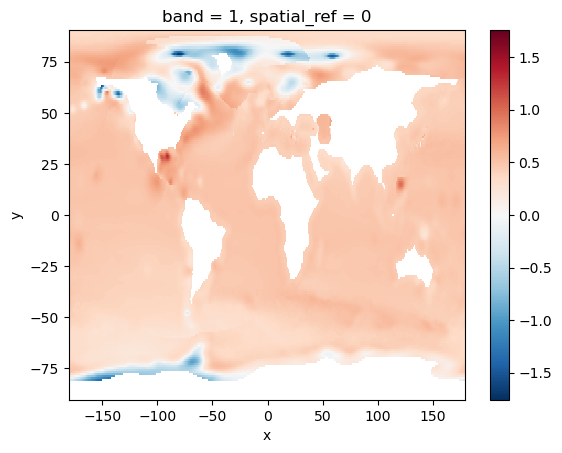

In [10]:
df = ar_df_dict["AR6"]
row_selected = df[(df['CCS'] == ccs6) & (df['YRS'] == yr) & (df['ENS'] == str(float(ens)))].iloc[0]
ar6_item = rio.open_rasterio(row_selected.href, masked=True)
ar6_item = ar6_item / 1000
ar6_item.plot()

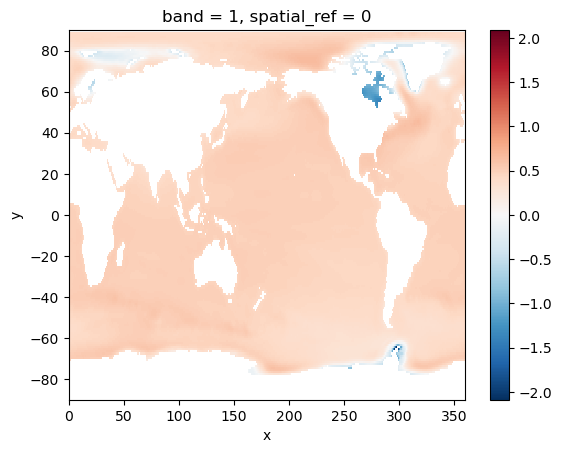

In [11]:
df = ar_df_dict["AR5"]
row_selected = df[(df['CCS'] == ccs5) & (df['YRS'] == yr) & (df['ENS'] == str(float(ens)))].iloc[0]
ar5_item = rio.open_rasterio(row_selected.href, masked=True)
ar5_item.plot()

In [13]:
sc_col = catalog.get_child("sc")
href_sc = sc_col.assets["data"].href

ds = xr.open_zarr(href_sc)
ds

<xarray.Dataset> Size: 124MB
Dimensions:           (nensemble: 7, stations: 518005, nscenarios: 2, time: 2)
Coordinates:
    ensemble          (nensemble) |S3 21B dask.array<chunksize=(7,), meta=np.ndarray>
    lat               (stations) float64 4MB dask.array<chunksize=(64751,), meta=np.ndarray>
    lon               (stations) float64 4MB dask.array<chunksize=(64751,), meta=np.ndarray>
    scenarios         (nscenarios) |S5 10B dask.array<chunksize=(2,), meta=np.ndarray>
  * time              (time) int32 8B 2050 2100
Dimensions without coordinates: nensemble, stations, nscenarios
Data variables:
    shoreline_change  (nscenarios, stations, time, nensemble) float64 116MB dask.array<chunksize=(1, 64751, 1, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    crs:          4326
    description:  Projections of global shoreline change in view of climate c...
    source:       The procedure to produce the dataset and the findings are d...
    title:        Global shoreline change projections for the year 2050 under...

In [14]:
sc_col = catalog.get_child("ssl")
href_sc = sc_col.assets["data"].href

# Printing the dataset object shows the storm surge level consists of three dimensions.
# Every storm surge level is associated with a certain station, scenario and revisting period.
ds = xr.open_zarr(href_sc)
ds

<xarray.Dataset> Size: 466kB
Dimensions:    (stations: 2242, rp: 8, nscenarios: 3)
Coordinates:
    lat        (stations) float64 18kB dask.array<chunksize=(2242,), meta=np.ndarray>
    lon        (stations) float64 18kB dask.array<chunksize=(2242,), meta=np.ndarray>
  * rp         (rp) float32 32B 5.0 10.0 20.0 50.0 100.0 200.0 500.0 1e+03
    scenarios  (nscenarios) |S10 30B dask.array<chunksize=(3,), meta=np.ndarray>
Dimensions without coordinates: stations, nscenarios
Data variables:
    ssl        (nscenarios, stations, rp) float64 430kB dask.array<chunksize=(2, 2242, 8), meta=np.ndarray>
Attributes: (12/13)
    Conventions:      CF-1.8
    End_date:         30-Nov-2004 21:00:00
    Institution:      Joint European Research Center, Institute of Environmen...
    Project_Acronym:  CoastAlRisk
    Project_Name:     Prototype of a first Global Integrated Coastal Impact-b...
    Starting_date:    01-Dec-1969
    ...               ...
    disclaimer:       Unless the following would not be permitted or valid un...
    email:            michail.vousdoukas@ec.europa.eu
    reference:        Vousdoukas MI, Voukouvalas E, Annunziato A, Giardino A,...
    terms_for_use:    European Union, 1995-2015.\nReuse is authorised, provid...
    title:            European extreme storm surge level
    version:          1.0

In [12]:
# TODO: plot on map

### Open data from second catalog (world pop & subsidence)

In [22]:
# load the GCA SOTC STAC catalog
catalog2 = pystac_client.Client.open(
    "https://storage.googleapis.com/dgds-data-public/gca/SOTC/gca-sotc/catalog.json"
    # "https://storage.googleapis.com/dgds-data-public/gca/gca-stac/catalog.json"
)
# catalog
# see visually here: https://radiantearth.github.io/stac-browser/#/external/storage.googleapis.com/dgds-data-public/gca/SOTC/gca-sotc/catalog.json

# list the datasets present in the catalog, we are interested in the slp5 and slp6 sets
list(catalog2.get_children())

[<CollectionClient id=shore_mon_fut>,
 <CollectionClient id=sed_class>,
 <CollectionClient id=shore_mon>,
 <CollectionClient id=shore_mon_hr>,
 <CollectionClient id=shore_mon_drivers>,
 <CollectionClient id=esl_gwl>,
 <CollectionClient id=sub_threat>,
 <CollectionClient id=Exp_world_pop>,
 <CollectionClient id=Exp_world_pop_parquet>,
 <CollectionClient id=Haz-ESL>,
 <CollectionClient id=Vul-Inf_Mort>,
 <CollectionClient id=Exp-NS_Slopes>,
 <CollectionClient id=Vul_MYS>,
 <CollectionClient id=Vul_RS>,
 <CollectionClient id=Vul-GDP_Cap>,
 <CollectionClient id=Haz-Land_Sub_2010_COGs>,
 <CollectionClient id=Haz-Land_Sub_2040_COGs>,
 <CollectionClient id=Vul-Roads_Density_COGs>,
 <CollectionClient id=Exp-Delta_DEM_COGs>,
 <CollectionClient id=Haz-ERA5_93-23>,
 <CollectionClient id=Vul_World_Protected_Areas>,
 <CollectionClient id=Haz-MRI-ESM2-0_Hind_93-14>,
 <CollectionClient id=Haz-MPI-ESM1-2-LR_Hind_93-14>,
 <CollectionClient id=Haz-KIOST-ESM_Hind_93-14>,
 <CollectionClient id=Haz-IPSL-CM

In [17]:
sub_col = catalog2.get_child("Haz-Land_Sub_2040_COGs")
items_sub_df = get_collection_df(sub_col)
items_sub_df

Available assets in collection:
  - thumbnail: https://storage.googleapis.com/dgds-data-public/gca/SOTC/Haz-Land_Sub_2040_COGs/Land_Subsidence.png

No parquet asset found, using get_items() with progress tracking...
Loading items from collection: Haz-Land_Sub_2040_COGs
Loaded 50 items...
Loaded 100 items...
Loaded 150 items...
Loaded 200 items...
Loaded 250 items...
Loaded 300 items...
Loaded 350 items...
Loaded 400 items...
Loaded 450 items...
Loaded 500 items...
Loaded 550 items...
Loaded 600 items...
Loaded 650 items...
Loaded 700 items...
Loaded 750 items...
Loaded 800 items...
Loaded 850 items...
Loaded 900 items...


c:\Users\athanasi\AppData\Local\miniforge3\envs\idp-dashboard\Lib\site-packages\pystac_client\collection_client.py:153: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("ITEM_SEARCH")


Loaded 950 items...
Loaded 1000 items...
Loaded 1050 items...
Loaded 1100 items...
Loaded 1150 items...
Loaded 1200 items...
Loaded 1250 items...
Loaded 1300 items...
Loaded 1350 items...
Loaded 1400 items...
Loaded 1450 items...
Loaded 1500 items...
Loaded 1550 items...
Loaded 1600 items...
Loaded 1650 items...
Loaded 1700 items...
Loaded 1750 items...
Loaded 1800 items...
Loaded 1850 items...
Loaded 1900 items...
Loaded 1950 items...
Loaded 2000 items...
Loaded 2050 items...
Loaded 2100 items...
Loaded 2150 items...
Loaded 2200 items...
Loaded 2250 items...
Loaded 2300 items...
Loaded 2350 items...
Loaded 2400 items...
Loaded 2450 items...
Loaded 2500 items...
Loaded 2550 items...
Loaded 2600 items...
Loaded 2650 items...
Loaded 2700 items...
Loaded 2750 items...
Loaded 2800 items...
Loaded 2850 items...
Loaded 2900 items...
Loaded 2950 items...
Loaded 3000 items...
Loaded 3050 items...
Loaded 3100 items...
Loaded 3150 items...
Loaded 3200 items...
Loaded 3250 items...
Loaded 3300 it

,type,stac_version,stac_extensions,id,bbox,links,collection,geometry.type,geometry.coordinates,properties.created,...,properties.proj:transform,properties.deltares:item_key,properties.datetime,assets.band_data.href,assets.band_data.type,assets.band_data.title,assets.band_data.file:size,assets.band_data.raster:bands,assets.band_data.eo:bands,assets.band_data.roles
0,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,B01_x-102.0_y-1.0,"[-102.00000000003119, -0.999999999963637, -99....","[{'rel': 'collection', 'href': '../collection....",Haz-Land_Sub_2040_COGs,Polygon,"[[[-99.0000000000324, -0.999999999963637], [-9...",2024-02-22T01:21:47.627690Z,...,"[0.00833333333332999, 0.0, -102.00000000003119...",B01_x-102.0_y-1.0,2040-01-01T00:00:00Z,https://storage.googleapis.com/dgds-data-publi...,image/tiff; application=geotiff; profile=cloud...,band_data,4314,"[{'nodata': 0, 'data_type': 'uint8', 'spatial_...","[{'name': 'band_data', 'description': 'Potenti...",[data]
1,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,B01_x-102.0_y-10.0,"[-102.00000000003119, -9.99999999996004, -99.0...","[{'rel': 'collection', 'href': '../collection....",Haz-Land_Sub_2040_COGs,Polygon,"[[[-99.0000000000324, -9.99999999996004], [-99...",2024-02-22T01:21:47.981965Z,...,"[0.00833333333332999, 0.0, -102.00000000003119...",B01_x-102.0_y-10.0,2040-01-01T00:00:00Z,https://storage.googleapis.com/dgds-data-publi...,image/tiff; application=geotiff; profile=cloud...,band_data,4314,"[{'nodata': 0, 'data_type': 'uint8', 'spatial_...","[{'name': 'band_data', 'description': 'Potenti...",[data]
2,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,B01_x-102.0_y-13.0,"[-102.00000000003119, -12.999999999958833, -99...","[{'rel': 'collection', 'href': '../collection....",Haz-Land_Sub_2040_COGs,Polygon,"[[[-99.0000000000324, -12.999999999958833], [-...",2024-02-22T01:21:48.334794Z,...,"[0.00833333333332999, 0.0, -102.00000000003119...",B01_x-102.0_y-13.0,2040-01-01T00:00:00Z,https://storage.googleapis.com/dgds-data-publi...,image/tiff; application=geotiff; profile=cloud...,band_data,4314,"[{'nodata': 0, 'data_type': 'uint8', 'spatial_...","[{'name': 'band_data', 'description': 'Potenti...",[data]
3,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,B01_x-102.0_y-16.0,"[-102.00000000003119, -15.99999999995764, -99....","[{'rel': 'collection', 'href': '../collection....",Haz-Land_Sub_2040_COGs,Polygon,"[[[-99.0000000000324, -15.99999999995764], [-9...",2024-02-22T01:21:48.671248Z,...,"[0.00833333333332999, 0.0, -102.00000000003119...",B01_x-102.0_y-16.0,2040-01-01T00:00:00Z,https://storage.googleapis.com/dgds-data-publi...,image/tiff; application=geotiff; profile=cloud...,band_data,4314,"[{'nodata': 0, 'data_type': 'uint8', 'spatial_...","[{'name': 'band_data', 'description': 'Potenti...",[data]
4,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,B01_x-102.0_y-19.0,"[-102.00000000003119, -18.999999999956447, -99...","[{'rel': 'collection', 'href': '../collection....",Haz-Land_Sub_2040_COGs,Polygon,"[[[-99.0000000000324, -18.999999999956447], [-...",2024-02-22T01:21:48.990343Z,...,"[0.00833333333332999, 0.0, -102.00000000003119...",B01_x-102.0_y-19.0,2040-01-01T00:00:00Z,https://storage.googleapis.com/dgds-data-publi...,image/tiff; application=geotiff; profile=cloud...,band_data,4314,"[{'nodata': 0, 'data_type': 'uint8', 'spatial_...","[{'name': 'band_data', 'description': 'Potenti...",[data]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5635,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,B01_x99.0_y71.0,"[98.99999999988842, 71.00000000000757, 101.999...","[{'rel': 'collection', 'href': '../collection....",Haz-Land_Sub_2040_COGs,Polygon,"[[[101.99999999988722, 71.00000000000757], [10...",2024-02-22T01:46:43.158651Z,...,"[0.008333333333330029, 0.0, 98.99999999988842,...",B01_x99.0_y71.0,2040-01-01T00:00:00Z,https://storage.googleapis.com/dgds-data-publ

In [19]:
# parquet file
pop_col = catalog2.get_child("Exp_world_pop_parquet")
pop_col


<CollectionClient id=Exp_world_pop_parquet>

In [23]:
# TODO: open parquet file
href_pop = pop_col.assets["data"].href
href_pop

'gs://dgds-data-public/gca/SOTC/Exp_world_pop.parquet/*.parquet'

In [ ]:
# pd.read_parquet(href_pop, engine='pyarrow')

: 

: 